## **ZAF004 - Emotion Detection**
#### Emotion detection of person whether he/she is sad, angry, happy or neural using python face emotion recognition library.

* FER - 2013 and data collected from web

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import numpy as np
import pandas as pd
import random
import h5py
import cv2
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

import imageio
import imgaug as ia
import imgaug.augmenters as iaa

import tensorflow as tf
from keras import regularizers
from keras import optimizers
from keras.models import Sequential
from keras.optimizers import RMSprop,SGD,Adam
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [39]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
data = df.copy()
data.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [40]:
data.shape

(28709, 2)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


Since project methodology is concerned with angry, happy, sad and neutral. Let's seperate them from our DataFrame.

In [42]:
# extracting anger:0, happiness:3, sad:4, neutral:6 from the dataframe data

emotions = ['Angry', 'Happy', 'Sad', 'Neutral']

data.set_index('emotion', inplace=True)
data = data.loc[[0,3,4,6]]
data.reset_index(inplace=True)
data.loc[data['emotion'] == 3, 'emotion'] = 1
data.loc[data['emotion'] == 4, 'emotion'] = 2
data.loc[data['emotion'] == 6, 'emotion'] = 3
print('Unique values:', data.emotion.unique())
data.head()

Unique values: [0 1 2 3]


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,0,30 24 21 23 25 25 49 67 84 103 120 125 130 139...
3,0,123 125 124 142 209 226 234 236 231 232 235 22...
4,0,8 9 14 21 26 32 37 46 52 62 72 70 71 73 76 83 ...


In [43]:
# Emotions

emo = pd.DataFrame(data.emotion.value_counts().sort_index(ascending=True))
emo.rename(columns={'emotion':'Count'}, inplace=True)
emo['Emotion'] = emotions
emo

,Count,Emotion
0,3995,Angry
1,7215,Happy
2,4830,Sad
3,4965,Neutral


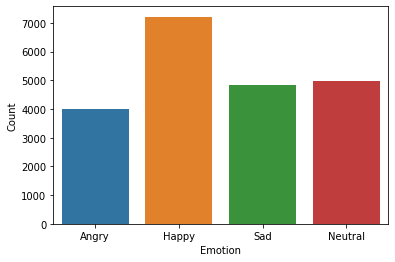

In [44]:
sns.barplot(x = emo.Emotion, y = emo.Count)
plt.show()

We can observe a class imbalance in the above, let's try to balance it later.

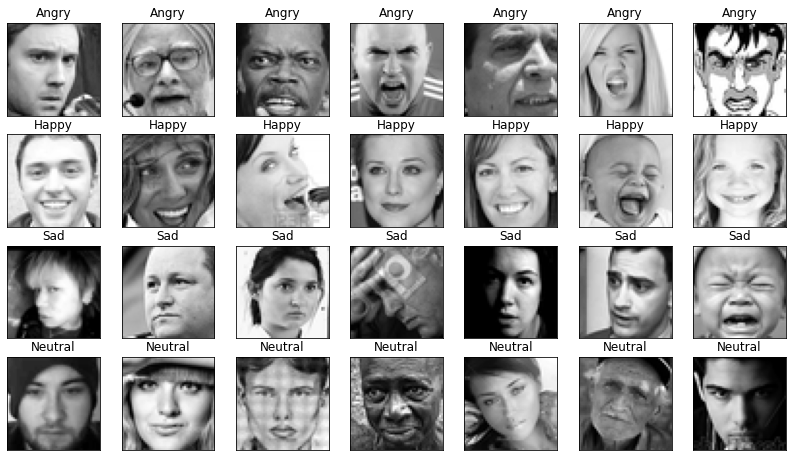

In [45]:
# let's plot some sample images of each emotions

plt.figure(figsize=(14, 14))
k = 0
for label in range(len(emotions)):
    for j in range(7):
        px = data[data.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        
        k += 1
        plt.subplot(7, 7, k)
        plt.imshow(px, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(emotions[label])
        plt.tight_layout   
plt.show()

In [10]:
# Data Preparation

IMG_SIZE = 48
training = []

for i in range(len(data)):
    img_array = np.matrix(data.pixels[i]).reshape(48,48).astype('float32')
    class_num = data.emotion[i]
    training.append([img_array, class_num])

training[0]

[matrix([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
         [ 65.,  61.,  58., ...,  56.,  52.,  44.],
         [ 50.,  43.,  54., ...,  49.,  56.,  47.],
         ...,
         [ 91.,  65.,  42., ...,  72.,  56.,  43.],
         [ 77.,  82.,  79., ..., 105.,  70.,  46.],
         [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32), 0]

In [11]:
# Data Preprocessing

def preprocessing(training, n):
    # shuffling the dataset
    random.shuffle(training)

    # assigning labels and features

    X = []
    y = []
    for features, label in training:
        X.append(features)
        y.append(label)

    # resizing features in accordance with CNN(we have gray images)
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

    # Normalising X and converting labels to categorical features
    X = X.astype('float32')
    X /= 255

    y = np_utils.to_categorical(y,n)

    # splitting X and y for use in CNN
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    return X_train, X_test, y_train, y_test

In [12]:
# getting our data

X_train, X_test, y_train, y_test = preprocessing(training, len(emotions))
X_train.shape, X_test.shape

((16804, 48, 48, 1), (4201, 48, 48, 1))

### Model 1

In [54]:
# let's build our model

def build_model():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
              
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(4, activation='softmax'))
    
    model.summary()
    return model

In [55]:
# callbacks

model_name = 'EmotionDetectionModel1.h5'
checkpoint = ModelCheckpoint(model_name,
                            monitor='val_loss',
                            mode='auto',
                            verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=4,
                         verbose=1,
                         restore_best_weights=True)
redudeLR = ReduceLROnPlateau(monitor='val_loss',
                            factor = 0.2,
                            patience=2,
                            verbose=1,
                            min_delta=0.0001)
callbacks = [earlystop, checkpoint, redudeLR]

In [56]:
# compiling our model

model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
history = model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=20, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 conv2d_41 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 12, 12, 32)      

132/132 [==============================] - 1s 3ms/step
Accuracy Score: 0.6593668174244227


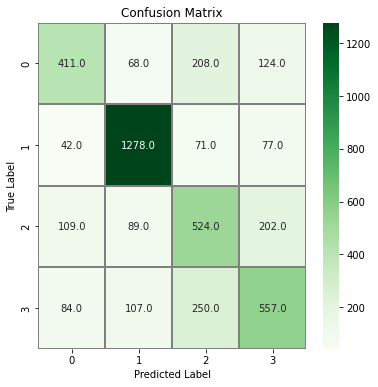

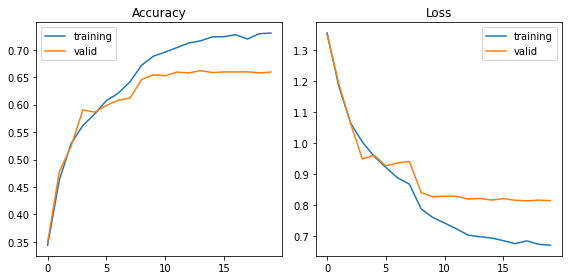

In [57]:
def model_metrics(y_test, y_pred):

  # compute the confusion matrix
  confusion_mtx = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
  # plot the confusion matrix
  f,ax = plt.subplots(figsize=(6, 6))
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

def plotting(history):

  plt.figure(figsize=(8,4))
  
  plt.subplot(1, 2, 1)
  sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='training')
  sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
  plt.title('Accuracy')

  plt.subplot(1, 2, 2)
  sns.lineplot(x=history.epoch, y=history.history['loss'], label='training')
  sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
  plt.title('Loss')

  plt.tight_layout()
  plt.show()

y_pred = model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
model_metrics(y_test, y_pred)
plotting(history)


### Model 2

In [61]:
# let's build our model

def build_model1():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
        
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten()) 
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
        
    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(4, activation='softmax'))
    
    model.summary()
    return model

In [59]:
# callbacks

model_name = 'EmotionDetectionModel2.h5'
checkpoint = ModelCheckpoint(model_name,
                            monitor='val_loss',
                            mode='auto',
                            verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=4,
                         verbose=1,
                         restore_best_weights=True)
redudeLR = ReduceLROnPlateau(monitor='val_loss',
                            factor = 0.2,
                            patience=2,
                            verbose=1,
                            min_delta=0.0001)
callbacks = [earlystop, checkpoint, redudeLR]

In [60]:
# compiling our model

model1 = build_model1()
model1.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
history1 = model1.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=20, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_46 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 24, 24, 128)      

132/132 [==============================] - 1s 6ms/step
Accuracy Score: 0.6955486788859795


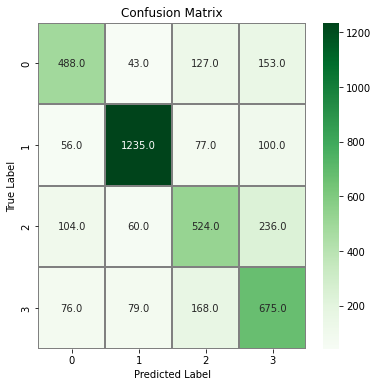

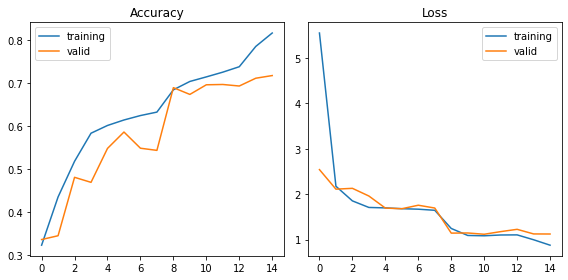

In [62]:
y_pred = model1.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
model_metrics(y_test, y_pred)
plotting(history1)

* We are gonna go ahead with the second model we created

### Data Augmentation

In [63]:
# flipping horizontally and vertically
def flipping(img):
    # horizontal
    hflip = iaa.Fliplr(p=1.0)
    imgH = hflip.augment_image(img)

    # vertical
    vflip = iaa.Flipud(p=1.0)
    imgV = vflip.augment_image(img)

    return imgH, imgV

# rotating by 45 and 90
def rotation(img):
    rot1 = iaa.Rotate((-45, 45))
    img1 = rot1.augment_image(img)

    rot2 = aug = iaa.Rotate((-90, 90))
    img2 = rot2.augment_image(img)

    return img1, img2

# adding some noise i.e. blurring our image
def noise(img):
    noise=iaa.AdditiveGaussianNoise(10,10)
    input_noise=noise.augment_image(img)

    return input_noise

In [64]:
# adding augmented images using above function and adding to our training data

training_aug = training.copy()
for i in range(len(training)):
    img = training[i][0]

    imgH, imgV = flipping(img)
    img45, img90 = rotation(img)
    noisee = noise(img)

    augmented = [imgH, imgV, img45, img90, noisee]
    for aug in augmented:
        training_aug.append([aug, training[i][1]])

# getting our data

X_train, X_test, y_train, y_test = preprocessing(training_aug, len(emotions))
X_train.shape, X_test.shape   

((100824, 48, 48, 1), (25206, 48, 48, 1))

In [66]:
# callbacks

model_name = 'EmotionDetectionModelAug.h5'
checkpoint = ModelCheckpoint(model_name,
                            monitor='val_loss',
                            mode='auto',
                            verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=4,
                         verbose=1,
                         restore_best_weights=True)
redudeLR = ReduceLROnPlateau(monitor='val_loss',
                            factor = 0.2,
                            patience=2,
                            verbose=1,
                            min_delta=0.0001)
callbacks = [earlystop, checkpoint, redudeLR]

In [68]:
# compiling our model

model2 = build_model1()
model2.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=20, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_56 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_30 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_57 (Conv2D)          (None, 24, 24, 128)     

788/788 [==============================] - 4s 5ms/step
Accuracy Score: 0.7069745298738396


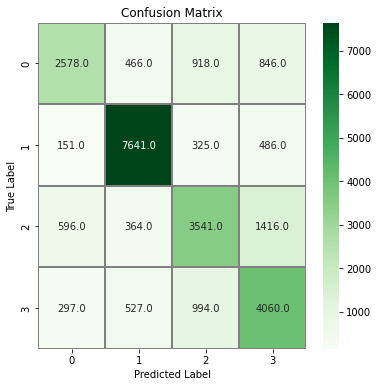

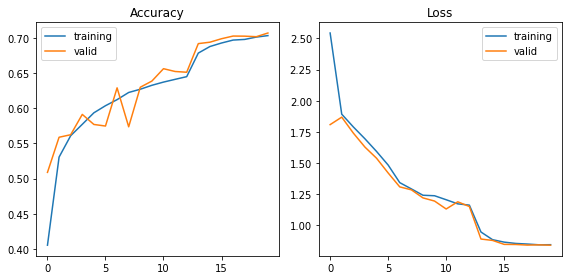

In [70]:
y_pred = model2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
model_metrics(y_test, y_pred)
plotting(history2)

### Balancing Classes(Adding 'angry' data)

In [71]:
training_bal = training.copy()
count = 0
index = [] # index of all the non valid data

img_dir = '/content/drive/MyDrive/Colab Notebooks/Angry'
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

for file in os.listdir(img_dir):
    path = img_dir+'/'+file
    #print(path)
    img = cv2.imread(path, 0)

    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    for (x,y,w,h) in faces:
        img = img[y:y+h, x:x+w]
        shape = img.shape
        if shape[0] == 0 or shape[1] == 0:
            index.append(img)
            continue
        else:
            img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST).astype('float32')
            training_bal.append([img, emotions.index('Angry')])
            count += 1

print(count)
print('Image Added:',(count - len(index)))

866
Image Added: 817


In [72]:
x = []
for data in training_bal:
    x.append(data[1])

pd.Series(x).value_counts()

1    7215
3    4965
0    4861
2    4830
dtype: int64

All the other classes seem balanced except the happy class for which we have much more data.

In [73]:
# getting our data

X_train, X_test, y_train, y_test = preprocessing(training_bal, len(emotions))
X_train.shape, X_test.shape   

((17496, 48, 48, 1), (4375, 48, 48, 1))

In [74]:
# callbacks

model_name = 'EmotionDetectionModelBal.h5'
checkpoint = ModelCheckpoint(model_name,
                            monitor='val_loss',
                            mode='auto',
                            verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=4,
                         verbose=1,
                         restore_best_weights=True)
redudeLR = ReduceLROnPlateau(monitor='val_loss',
                            factor = 0.2,
                            patience=2,
                            verbose=1,
                            min_delta=0.0001)
callbacks = [earlystop, checkpoint, redudeLR]

In [75]:
# compiling our model

model3 = build_model1()
model3.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=20, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_61 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_36 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_51 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 24, 24, 128)     

137/137 [==============================] - 1s 6ms/step
Accuracy Score: 0.7261714285714286


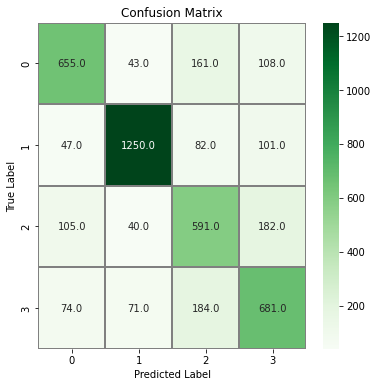

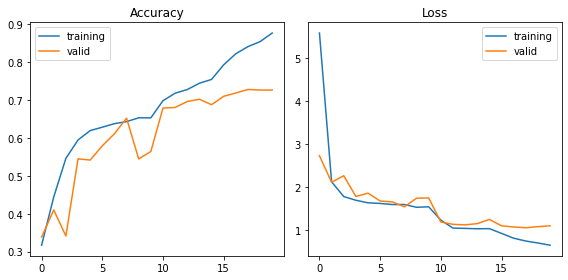

In [76]:
y_pred = model3.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
model_metrics(y_test, y_pred)
plotting(history3)

In [100]:
# RESULTS from all the above model

results = pd.DataFrame()
results.index = history.epoch[:15]
results['model_acc'] = history.history['accuracy'][:15]
results['model_valAcc'] = history.history['val_accuracy'][:15]
results['model_loss'] = history.history['loss'][:15]
results['model_valLoss'] = history.history['val_loss'][:15]
results.index = history.epoch[:15]
results['model1_acc'] = history1.history['accuracy'][:15]
results['model1_valAcc'] = history1.history['val_accuracy'][:15]
results['model1_loss'] = history1.history['loss'][:15]
results['model1_valLoss'] = history1.history['val_loss'][:15]
results.index = history.epoch[:15]
results['model2_acc'] = history2.history['accuracy'][:15]
results['model2_valAcc'] = history2.history['val_accuracy'][:15]
results['model2_loss'] = history2.history['loss'][:15]
results['model2_valLoss'] = history2.history['val_loss'][:15]
results.index = history.epoch[:15]
results['model3_acc'] = history3.history['accuracy'][:15]
results['model3_valAcc'] = history3.history['val_accuracy'][:15]
results['model3_loss'] = history3.history['loss'][:15]
results['model3_valLoss'] = history3.history['val_loss'][:15]

results

,model_acc,model_valAcc,model_loss,model_valLoss,model1_acc,model1_valAcc,model1_loss,model1_valLoss,model2_acc,model2_valAcc,model2_loss,model2_valLoss,model3_acc,model3_valAcc,model3_loss,model3_valLoss
0,0.343847,0.349441,1.354109,1.348533,0.322959,0.336110,5.549638,2.542496,0.405499,0.508966,2.543166,1.808276,0.316930,0.338286,5.582712,2.729132
1,0.462925,0.477981,1.181689,1.190176,0.435015,0.344918,2.176199,2.112295,0.530647,0.558875,1.891994,1.868284,0.444216,0.409829,2.123525,2.112688
2,0.529160,0.524399,1.063915,1.062014,0.517793,0.480600,1.854224,2.130508,0.561047,0.562445,1.789647,1.740445,0.546068,0.341257,1.781320,2.264846
3,0.562009,0.590336,1.002524,0.947470,0.583075,0.468936,1.709664,1.961484,0.577234,0.591327,1.694657,1.628120,0.594422,0.544686,1.694330,1.782023
4,0.582897,0.586289,0.956417,0.959804,0.601047,0.547727,1.699809,1.695627,0.593599,0.577045,1.593166,1.538820,0.619284,0.541486,1.635129,1.860214
5,0.607296,0.598429,0.920625,0.925762,0.613782,0.585813,1.682355,1.681280,0.603676,0.574784,1.484134,1.420563,0.628144,0.578971,1.620617,1.676816
6,0.620626,0.607951,0.886763,0.934835,0.624078,0.548203,1.671299,1.758584,0.612295,0.629057,1.343024,1.308901,0.637517,0.610971,1.595207,1.656816
7,0.641454,0.611759,0.866622,0.939906,0.632111,0.543204,1.647043,1.696854,0.622491,0.573713,1.292774,1.285335,0.642947,0.651886,1.595425,1.542524
8,0.671864,0.645799,0.786911,0.839520,0.683885,0.688884,1.247086,1.144608,0.627083,0.629929,1.241871,1.220679,0.652949,0.544457,1.531298,1.741871
9,0.688408,0.654368,0.758792,0.825744,0.703285,0.673173,1.093249,1.147764,0.632687,0.638697,1.237863,1.195224,0.652892,0.564114,1.542376,1.749021
